<a href="https://colab.research.google.com/github/hasnaa19/Cinema-Booking-System/blob/main/RPS_Cropping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import os
!pip install patchify
from patchify import patchify, unpatchify
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.layers import MaxPooling2D

from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras import activations
from tqdm import tqdm
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.utils import class_weight
from tensorflow.keras.metrics import MeanIoU
import statistics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# def Load_Augment_data(): 
#     X_DIR = '/content/drive/MyDrive/Graduation Project 2/Original'
#     Y_DIR = '/content/drive/MyDrive/Graduation Project 2/G1'
#     Images_train=[]
#     Masks_train = []
#     Images_test= []
#     Masks_test = []
#     test_ex = [18, 47, 78, 120]
#     for i in range(1,121):

#       X_path = str(i)+'.jpg'
#       Y_path = str(i)+'.png'
#       X_path = os.path.join(X_DIR, X_path)
#       Y_path = os.path.join(Y_DIR, Y_path)
#       image = cv2.imread(X_path)
#       mask = cv2.imread(Y_path, cv2.IMREAD_GRAYSCALE)

#       patches_img = patchify(image, (300,400,3), step=300)
#       patches_mask = patchify(mask, (300,400), step=300)

#       patches_img = patches_img.reshape(-1,300,400,3)
#       patches_mask = patches_mask.reshape(-1,300,400)
#       if i in test_ex:
#         Images_test.append(patches_img)
#         Masks_test.append(patches_mask)
#       else:
#         Images_train.append(patches_img)
#         Masks_train.append(patches_mask)

#     Images_train = np.array(Images_train).reshape(-1, 300,400,3)
#     Masks_train = np.array(Masks_train).reshape(-1, 300,400)
#     Images_test = np.array(Images_test).reshape(-1, 300,400,3)
#     Masks_test = np.array(Masks_test).reshape(-1, 300,400)

#     return Images_train, Masks_train, Images_test, Masks_test

In [7]:
# Images_train, Masks_train, Images_test, Masks_test = Load_Augment_data()
# Images_test = (Images_test/255).astype('float16')  #division for normalizing, casting bec after division dtype will change from uint8 to float64, ie dataset size will inc by factor of *8 causing RAM to fill and session to crash 
# Masks_test = (Masks_test/255).astype('uint8')
# Images_train = (Images_train/255).astype('float16')
# Masks_train = (Masks_train/255).astype('uint8')


In [8]:
# np.save('Images_train_16.npy', Images_train)
# np.save('Images_test_16.npy', Images_test)
# np.save('Masks_test.npy', Masks_test)
# np.save('Masks_train.npy', Masks_train)

# !cp -r "/content/Images_train_16.npy" "/content/drive/MyDrive/Graduation Project 2"
# !cp -r "/content/Images_test_16.npy" "/content/drive/MyDrive/Graduation Project 2"
# !cp -r "/content/Masks_train.npy" "/content/drive/MyDrive/Graduation Project 2"
# !cp -r "/content/Masks_test.npy" "/content/drive/MyDrive/Graduation Project 2"

In [ ]:
Images_train= np.load('/content/drive/MyDrive/Graduation Project 2/Images_train_16.npy')
Images_test = np.load('/content/drive/MyDrive/Graduation Project 2/Images_test_16.npy')
Masks_train = np.load('/content/drive/MyDrive/Graduation Project 2/Masks_train.npy')
Masks_test = np.load('/content/drive/MyDrive/Graduation Project 2/Masks_test.npy')

In [10]:
def RPS_encoder(x, nf):
    conv1 = Conv2D(nf,3, 1, padding ="same",activation='linear',kernel_initializer='he_normal')(x)
    conv1_n = BatchNormalization()(conv1)
    conv1_n =activations.relu(conv1_n)
    conv2=Conv2D(nf,3, 1, padding ="same",activation='linear',kernel_initializer='he_normal')(conv1_n)
    conc=Concatenate(axis=-1)([conv1,conv2])
    conv3=Conv2D(nf,1, 1, padding ="same",activation='linear', kernel_initializer='he_normal')(conc)
    conv3= BatchNormalization()(conv3)
    conv3=activations.relu(conv3)
    out = MaxPooling2D(pool_size=(2, 2), strides=2)(conv3)
    return out,conv1;

def RPS_decoder(conv1_E,Eout, nf1, nf2, pad, final):
    up = Conv2DTranspose(nf1,2,(2,2),padding='same')(Eout)
    if pad:
        paddings = tf.constant([[0,0], [1,0],[0,0],[0,0]])
        up = tf.pad(up, paddings, "SYMMETRIC")
    conv1 = Conv2D(nf1,3, 1, padding ="same",activation='linear', kernel_initializer='he_normal')(up)
    BN1 = BatchNormalization()(conv1)
    R1 = activations.relu(BN1)
    conv2 = Conv2D(nf2,3, 1, padding ="same",activation='linear', kernel_initializer='he_normal')(R1)
    Conc=Concatenate(axis=-1)([conv2,conv1,conv1_E])
    conv3=Conv2D(nf2,1, 1, padding ="same",activation='linear',kernel_initializer='he_normal')(Conc)
    BN2= BatchNormalization()(conv3)
    if not final:                         #the reason we commented this is that we using weighted loss function with logists that call sigmoid function within it's implementation
      D_out=activations.sigmoid(BN2)
    else:
      D_out=activations.relu(BN2)

    return D_out;

def RPS_Net():
    inputs = Input((300,400,3))
    out1,c1=RPS_encoder(inputs,64)
    out2,c2=RPS_encoder(out1,128)
    out3,c3=RPS_encoder(out2,256)
    out4,c4=RPS_encoder(out3,512)

    d1 = RPS_decoder(c4, out4, 512, 256,True, False)
    d2 = RPS_decoder(c3, d1, 256, 128,True, False)
    d3 = RPS_decoder(c2, d2, 128, 64, False, False)
    d4 = RPS_decoder(c1, d3, 64, 1, False, True)  

    model = Model(inputs=inputs, outputs=d4)
    return model

In [11]:
RPS = RPS_Net()
RPS.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300, 400, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 300, 400, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 300, 400, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [12]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001, epsilon =0.000001)
RPS.compile(optimizer=opt,loss= "binary_crossentropy", metrics=['Recall','Precision','AUC','accuracy'])
model_history = RPS.fit(Images_train, Masks_train, batch_size = 10, epochs=20, shuffle = True)

Epoch 1/20
279/279 [==============================] - 304s 947ms/step - loss: 0.4112 - recall: 0.1786 - precision: 0.0074 - auc: 0.5233 - accuracy: 0.8349
Epoch 2/20
279/279 [==============================] - 273s 980ms/step - loss: 0.0964 - recall: 0.0020 - precision: 0.0054 - auc: 0.6106 - accuracy: 0.9909
Epoch 3/20
279/279 [==============================] - 274s 981ms/step - loss: 0.0677 - recall: 7.9036e-05 - precision: 0.0016 - auc: 0.6599 - accuracy: 0.9930
Epoch 4/20
279/279 [==============================] - 274s 981ms/step - loss: 0.0679 - recall: 4.4653e-07 - precision: 0.0118 - auc: 0.6939 - accuracy: 0.9933
Epoch 5/20
279/279 [==============================] - 273s 980ms/step - loss: 0.0620 - recall: 3.2999e-04 - precision: 0.1469 - auc: 0.6841 - accuracy: 0.9933
Epoch 6/20
279/279 [==============================] - 273s 980ms/step - loss: 0.0570 - recall: 0.0000e+00 - precision: 0.0000e+00 - auc: 0.6886 - accuracy: 0.9933
Epoch 7/20
279/279 [==============================

In [13]:
# save model
tf.keras.models.save_model(RPS, '/content/drive/MyDrive/Graduation Project 2/Model_1', save_format='tf')

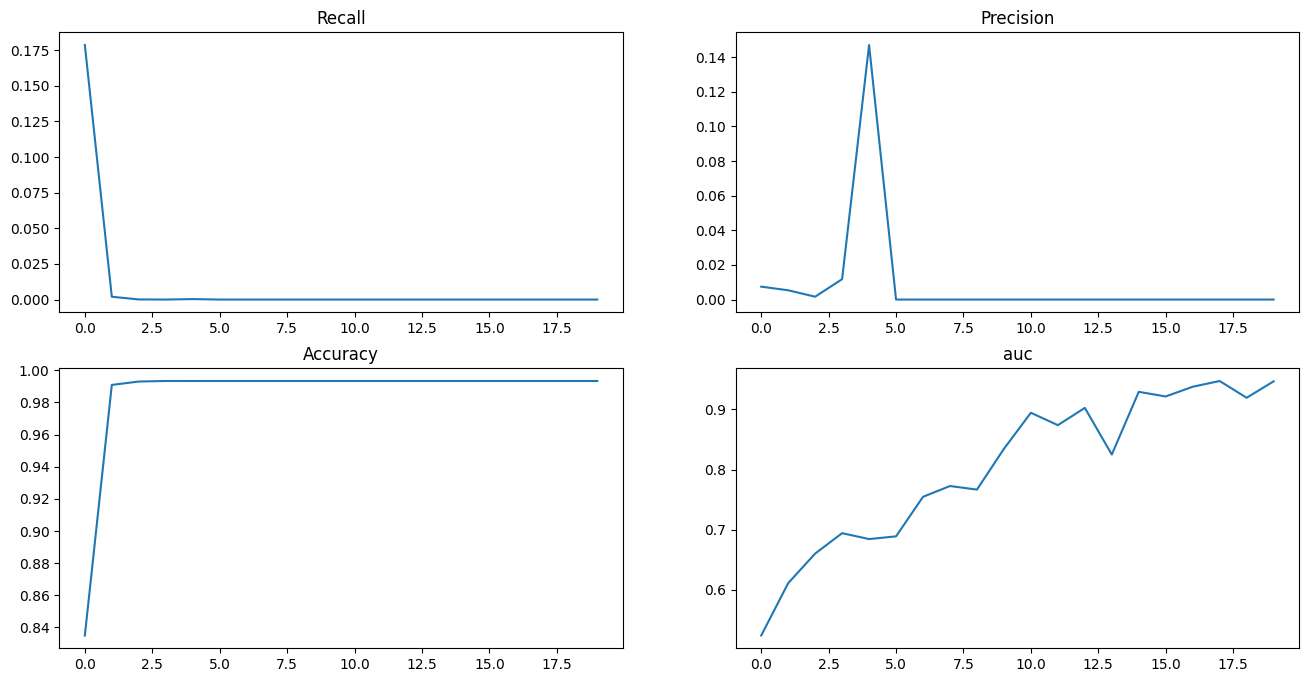

In [14]:
plt.figure(figsize=(16, 8))

plt.subplot(221)
plt.title('Recall')
plt.plot(model_history.history["recall"]) # kol myzed kol makan ashn

plt.subplot(222)
plt.title('Precision')
plt.plot(model_history.history["precision"]) # as it gets to -1 the better (kol my2el kol ma kan ahsn)

plt.subplot(223)
plt.title('Accuracy')
plt.plot(model_history.history["accuracy"])

plt.subplot(224)
plt.title('auc')
plt.plot(model_history.history["auc"])
plt.show()

In [15]:
print("Evaluate on test data")
results = RPS.evaluate(Images_test, Masks_test)
print("Test loss, Recall, Precision, AUC, Test acc:", results)

Evaluate on test data
3/3 [==============================] - 20s 888ms/step - loss: 0.0372 - recall: 0.0000e+00 - precision: 0.0000e+00 - auc: 0.9442 - accuracy: 0.9921
Test loss, Recall, Precision, AUC, Test acc: [0.03719469904899597, 0.0, 0.0, 0.9442254304885864, 0.9920707941055298]


In [3]:
# LOAD MODEL
RPS =tf.keras.models.load_model('/content/drive/MyDrive/Graduation Project 2/Model_1')

In [84]:
def Main(img, mask):
  patches_img = patchify(img, (300,400,3), step=370)
  print(patches_img.shape)
  patches_img = patches_img.reshape(-1,300,400,3)
  print(patches_img.shape)
  predictions = RPS.predict(patches_img)
  print(predictions.shape)
  
  pred_img = (predictions > 0.5)*1
  print(np.unique(pred_img))
  print(np.unique(mask))
  print(np.sum(pred_img ==1))
  print(np.sum(mask ==255))

  #reshape
  pred_img = tf.keras.layers.Resizing(1440, 2160, interpolation="nearest")(pred_img.reshape(1200,2000,1))
  print(pred_img.shape)
  # plot
  
  plt.figure(figsize=(16, 8))
  plt.gray()
  plt.subplot(231)
  plt.title('Input Image')
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.subplot(232)
  plt.title('Actual Mask')
  plt.imshow(mask, interpolation='nearest')
  plt.subplot(233)
  plt.title('Predicted Mask')
  plt.imshow(pred_img, interpolation='nearest')
  plt.show()

  

(4, 5, 1, 300, 400, 3)
(20, 300, 400, 3)
1/1 [==============================] - 0s 41ms/step
(20, 300, 400, 1)
[0 1]
[0]
3841
0
(1440, 2160, 1)


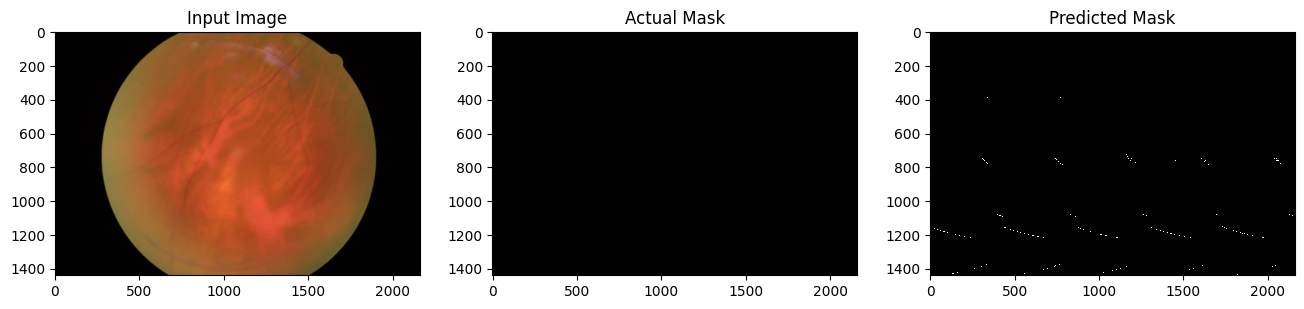

(4, 5, 1, 300, 400, 3)
(20, 300, 400, 3)
1/1 [==============================] - 0s 29ms/step
(20, 300, 400, 1)
[0 1]
[  0 255]
871
48991
(1440, 2160, 1)


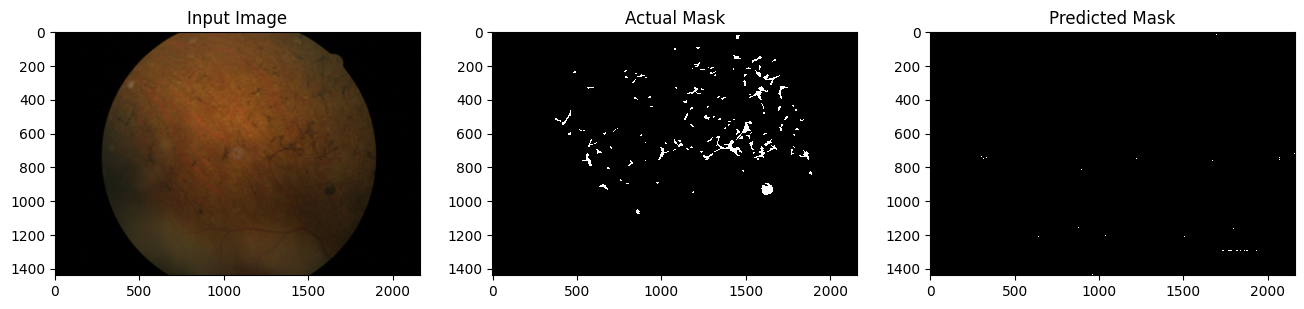

(4, 5, 1, 300, 400, 3)
(20, 300, 400, 3)
1/1 [==============================] - 0s 27ms/step
(20, 300, 400, 1)
[0 1]
[  0 255]
5414
16473
(1440, 2160, 1)


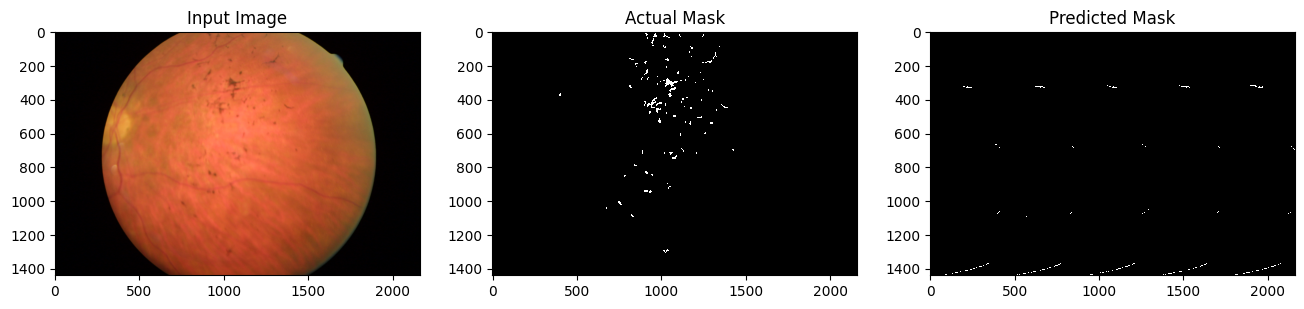

(4, 5, 1, 300, 400, 3)
(20, 300, 400, 3)
1/1 [==============================] - 0s 29ms/step
(20, 300, 400, 1)
[0 1]
[  0 255]
220
5723
(1440, 2160, 1)


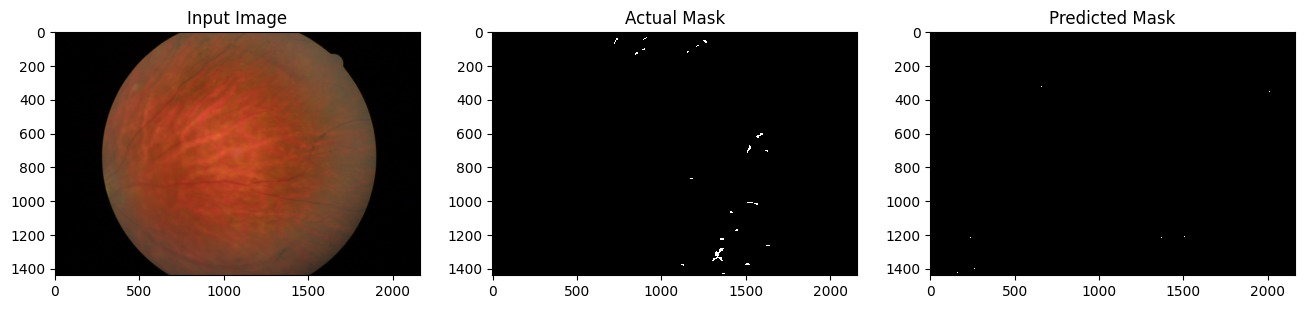

In [85]:

img = cv2.imread('/content/drive/MyDrive/Graduation Project 2/Original/18.jpg')
mask = cv2.imread('/content/drive/MyDrive/Graduation Project 2/G1/18.png', cv2.IMREAD_GRAYSCALE)
Main(img, mask)

img = cv2.imread('/content/drive/MyDrive/Graduation Project 2/Original/47.jpg')
mask = cv2.imread('/content/drive/MyDrive/Graduation Project 2/G1/47.png', cv2.IMREAD_GRAYSCALE)
Main(img, mask)

img = cv2.imread('/content/drive/MyDrive/Graduation Project 2/Original/78.jpg')
mask = cv2.imread('/content/drive/MyDrive/Graduation Project 2/G1/78.png', cv2.IMREAD_GRAYSCALE)
Main(img, mask)

img = cv2.imread('/content/drive/MyDrive/Graduation Project 2/Original/120.jpg')
mask = cv2.imread('/content/drive/MyDrive/Graduation Project 2/G1/120.png', cv2.IMREAD_GRAYSCALE)
Main(img, mask)
